# A DSL alongside a Genetic Algorithm applied to the ARC Dataset

In this notebook, we present a minimalistic *Domain Specific Language* for some ARC tasks. We also implement an evaluation function able to run a such program against an input image.

In a second time, we implement a simple genetic algorithm that is able to generate programs written in this DSL and demonstrate its usage on an ARC task.

!!begin

### Additions

* Added function to increase size of images - provides ability to representation on a 90x90 grid providing space around the image
* Additional scratchpad in the image - hidden colors on top of existing to indicate awareness of patterns to next operators - can be used for identifying filling, size/rank of objects, boundaries, special pixels, other features - this may not be necessary, since operators create multiple images, and other operators combine them.
* create operators 

In [68]:
%matplotlib inline

In [69]:
import functools
import operator
## see https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
def list_flatten(a):
    return functools.reduce(operator.iconcat, a, [])

In [70]:
import numpy as np
import pandas as pd
import itertools
import random

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

import ast
import re 

from joblib import Parallel, delayed
import multiprocessing

#data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')

data_path = Path('/media/SSD/Abstraction and Reasoning/')
training_path = data_path / 'training'
test_path = data_path / 'test'
program_path = data_path/'programs'

training_tasks = sorted(os.listdir(training_path))
testing_tasks = sorted(os.listdir(test_path))


# Plotting

!!plot

In [71]:
#
# This code is used to display a task
# It accepts 11 colors, one more than the images, in case we want to use it
# 

cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25','#4a4d4a'])
norm = colors.Normalize(vmin=0, vmax=10)
def plot_one(ax,task, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25','#4a4d4a'])
    norm = colors.Normalize(vmin=0, vmax=10)
    
    try:
        input_matrix = task[train_or_test][i][input_or_output]
    except KeyError:
        print("No",train_or_test,input_or_output)
    
    else:
    
        ax.imshow(input_matrix, cmap=cmap, norm=norm)
        ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
        ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
        ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(axs[0,i],task,i,'train','input')
        plot_one(axs[1,i],task,i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(axs[0],task,0,'test','input')
        plot_one(axs[1],task,0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(axs[0,i],task,i,'test','input')
            plot_one(axs[1,i],task,i,'test','output')  
    plt.tight_layout()
    plt.show() 

    
# Display each output of the function
def show_image_list(images):
    """ Show each image contained in a list. """
    p = plt.figure(figsize=[17,5]).subplots(1, len(images))
    
    if len(images) > 1:
        for i, image in enumerate(images):
            p[i].imshow(image, cmap=cmap, norm=norm)
    elif len(images) == 1:
        p.imshow(images[0], cmap=cmap, norm=norm)
    
    plt.show()

## Using some logical rule detection for analyzing the examples

In [72]:
data_frame = pd.DataFrame({'a': [0,1,1,1,0], 'b': [0,1,0,1,0], 'c': [0,0,0,1,0], 'd':[0,0,0,1,1], 'e': [1,1,1,1,0], 'f': [1,1,0,1,0], 'g': [0,1,1,0,0], 'h': [0,1,0,0,0], 'i': [0,0,0,0,0]})

In [73]:
data_frame = pd.DataFrame.from_dict({'1': [0,1,1,1,0], '2': [0,1,0,1,0], '3': [0,0,0,1,0], '4':[0,0,0,1,1], '5': [1,1,1,1,0], '6': [1,1,0,1,0], '7': [0,1,1,0,0], '8': [0,1,0,0,0], '9': [0,0,0,0,0]}, orient='index', columns = ['a','b','c','d','e'])

In [74]:
data_frame

,a,b,c,d,e
1,0,1,1,1,0
2,0,1,0,1,0
3,0,0,0,1,0
4,0,0,0,1,1
5,1,1,1,1,0
6,1,1,0,1,0
7,0,1,1,0,0
8,0,1,0,0,0
9,0,0,0,0,0


In [75]:
data_frame["na"] = 1-data_frame['a']

In [76]:
data_frame["nb"] = 1-data_frame['b']
data_frame["nc"] = 1-data_frame['c']
data_frame["nd"] = 1-data_frame['d']
data_frame["ne"] = 1-data_frame['e']

Item Tree Analysis

https://github.com/milansegedinac/kst
https://en.wikipedia.org/wiki/Item_tree_analysis

In [77]:
from kst import iita
from kst import hasse

In [78]:
response = iita(data_frame, v=1)

[(2, 1), (4, 3), (8, 5), (4, 6), (0, 3), (6, 7), (6, 5), (8, 9), (0, 1), (1, 9)]


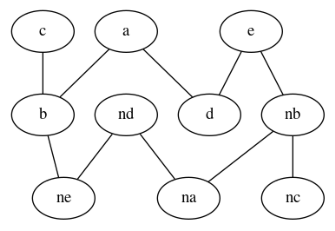

[]

In [93]:
hasse(response['implications'],10,labels = list(data_frame))

In [80]:
from sklearn import tree

In [81]:
clf = tree.DecisionTreeClassifier()

In [82]:
data_frame

,a,b,c,d,e,na,nb,nc,nd,ne
1,0,1,1,1,0,1,0,0,0,1
2,0,1,0,1,0,1,0,1,0,1
3,0,0,0,1,0,1,1,1,0,1
4,0,0,0,1,1,1,1,1,0,0
5,1,1,1,1,0,0,0,0,0,1
6,1,1,0,1,0,0,0,1,0,1
7,0,1,1,0,0,1,0,0,1,1
8,0,1,0,0,0,1,0,1,1,1
9,0,0,0,0,0,1,1,1,1,1


[Text(200.88000000000002, 181.2, 'X[1] <= 0.5\ngini = 0.198\nsamples = 9\nvalue = [1, 8]'),
 Text(133.92000000000002, 108.72, 'X[3] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

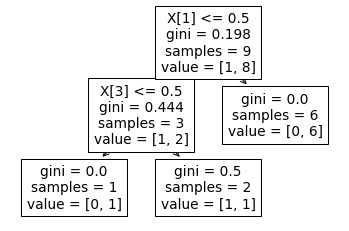

In [83]:
tree.plot_tree(clf.fit(data_frame[['a','b','c','d']], data_frame[['ne']]))

In [84]:
print(tree.export_text(clf.fit(data_frame[['a','b','c','d']], data_frame[['ne']]),feature_names = ['a','b','c','d']))

|--- b <= 0.50
|   |--- d <= 0.50
|   |   |--- class: 1
|   |--- d >  0.50
|   |   |--- class: 0
|--- b >  0.50
|   |--- class: 1



[Text(200.88000000000002, 181.2, 'X[1] <= 0.5\ngini = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(133.92000000000002, 108.72, 'X[3] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]')]

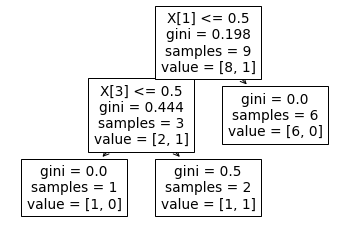

In [85]:
tree.plot_tree(clf.fit(data_frame[['a','b','c','d']], data_frame[['e']]))

# Task Analysis Functions
Used to characterize facts about a task


!!analysis

In [86]:


def analyze_size(task, ignore_test_after = True):
    
    #print("\n\nSize")
    
    
    # scan befores training and test
    di=np.zeros((0,2),int)
    for i, t in enumerate(task["train"]):
        t_in = np.array(t["input"])
        di = np.vstack([di, t_in.shape])
    
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        di = np.vstack([di, t_in.shape])
    #print(di) 
    
    # scan afters training and test
    do=np.zeros((0,2),int)
    for i, t in enumerate(task["train"]):
        t_in = np.array(t["output"])
        do = np.vstack([do, t_in.shape])
    
    if not ignore_test_after:
        for i, t in enumerate(task["test"]):
            t_in = np.array(t["input"])
            do = np.vstack([do, t_in.shape])
    #print(do)        
    
    
    
    
    
    d=np.zeros((len(task["train"]),4),int)
    
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        d[i] = [t_in.shape[0], t_in.shape[1], t_out.shape[0], t_out.shape[1]]
    
    
    
    d2=np.zeros((len(task["test"]),2),int)
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        d2[i] = [t_in.shape[0], t_in.shape[1]]


    #before_vert_test_train = np.unique(np.concatenate((d[:,0],d2[:,0])))
    #before_hor_test_train = np.unique(np.concatenate((d[:,1],d2[:,1])))
    
    before_vert_test_train = np.unique(di[:,0])
    before_hor_test_train = np.unique(di[:,1])
   
            
            
    #before_vert = np.unique(d[:,0])
    #before_hor = np.unique(d[:,1])
    #after_vert = np.unique(d[:,2])
    #after_hor = np.unique(d[:,3])
    
    before_vert = np.unique(di[:,0])
    before_hor = np.unique(di[:,1])
    after_vert = np.unique(do[:,0])
    after_hor = np.unique(do[:,1])
    
    #print("Unique before vertical:",before_vert_test_train)    
    #print("Unique before horizontal:",before_hor_test_train)
    #print("Unique after vertical:",after_vert)
    #print("Unique after horizontal:",after_hor)
    
    
    
    ## Before == const 1 and After == Const 2
    test1_before_vert = len(before_vert_test_train)  == 1
    test1_after_vert = len(after_vert) == 1
    test1_vert = test1_before_vert and test1_after_vert
    
    test1_before_hor = len(before_hor_test_train)  == 1
    test1_after_hor = len(after_hor) == 1
    test1_hor = test1_before_hor  == 1 and test1_after_hor
    
    ## Before == After == const
    test2_vert = test1_vert and before_vert_test_train[0] == after_vert[0]
    test2_hor = test1_hor and before_hor_test_train[0] == after_hor[0]
    
    ## Before(i) == After(i) all i
    #test3_vert = np.all(d[:,0] == d[:,2])
    #test3_hor = np.all(d[:,1] == d[:,3])
    test3_vert = np.all(di[0:do.shape[0],0] == do[:,0])  # ignore any outputs without inputs
    test3_hor = np.all(di[0:do.shape[0],1] == do[:,1])
    
    ##Test all Before are square
    #test4 = np.all(np.concatenate((d[:,0],d2[:,0])) == np.concatenate((d[:,1],d2[:,1])))
    test4 = np.all(di[:,0] == di[:,1])
    
    ## Test all After are square
    #test5 = np.all(d[:,2] == d[:,3])
    test5 = np.all(do[:,0] == do[:,1])

    if test1_before_vert:
        #print("Vertical: All Before ==",before_vert[0])
        test1_before_vert = before_vert[0]

    if test1_before_hor:
        #print("Horizontal: All Before ==",before_hor[0])
        test1_before_hor = before_hor[0]
        
    if test1_after_vert:
        #print("Vertical: All After ==",after_vert[0])
        test1_after_vert = after_vert[0]

    if test1_after_hor:
        #print("Horizontal: All After ==",after_hor[0])
        test1_after_hor = after_hor[0]       
                    
    
    if test2_vert:
        #print("Vertical: All Before == After  == const : ", before_vert[0])
        test2_vert = before_vert[0]
    
    if test2_hor:
        #print("Horizontal: All Before == After  == const : ", before_hor[0])
        test2_hor = before_hor[0]
        
    #if test3_vert:
        #print("Vertical: For all i Before(i) == After(i) == const:",d[:,0])
        
    
    #if test3_hor:
        #print("Horizontal: For all i Before(i) == After(i) == const:",d[:,1])

        
    #if test4:
        #print("All Befores are square.")
    #if test5:
        #print("All Afters are square")
      
    dt = {}
    dt["Befores are Square"] = test4
    dt["Afters are Square"] = test5
    dt["All Befores have same Vertical"] = test1_before_vert
    dt["All Befores have same Horizontal"] = test1_before_hor
    dt["All Afters have same Vertical"] = test1_after_vert
    dt["All Afters have same Horizontal"] = test1_after_hor
    dt["All Befores and Afters have same Vertical"] = test2_vert
    dt["All Befores and Afters have same Horizontal"] = test2_hor
    dt["Every Before and After has same Vertical"] = test3_vert
    dt["Every Before and After has same Horizontal"] = test3_hor
    
    
    return dt

In [87]:
def analyze_color(task, ignore_test_after = True):
    #print("\n\nColor")
    b=[]
    a=[]
    dt={}
    
    after_m_before={}
    before_m_after={}
    before_after_union={}
    before_after_intersection={}
    before_after_symdiff={}
    
    before_sets=[]
    after_sets=[]
    
    unions_after_m_before=set()
    
    for i, t in enumerate(task["train"]):
        
        before_set = set(list_flatten(t["input"]))
        after_set = set(list_flatten(t["output"]))
        

        
        before_sets.append(before_set)
        after_sets.append(after_set)
        
        
        after_m_before[i] = after_set-before_set
        before_m_after[i] = before_set-after_set
        before_after_union[i] = before_set | after_set
        before_after_intersection[i]=before_set & after_set
        before_after_symdiff[i] = before_set ^ after_set
        
        # collect some sets across the examples
        
        if i == 0:
            before_intersections = before_set
            after_intersections = after_set
            before_m_after_intersections = before_m_after[i]
        else:
            before_intersections = before_intersections & before_set
            after_intersections = after_intersections & after_set
            before_m_after_intersections = before_m_after_intersections & before_m_after[i]        
        
        unions_after_m_before = unions_after_m_before | after_m_before[i]
        
        
        
        #print("\nbefore set=",before_set)
        #print("after set=",after_set)
        #print("Union=",before_after_union[i])
        #print("Intersection=",before_after_intersection[i])
        #print("before-after set=",before_m_after[i])
        #print("after-before set=", after_m_before[i])
        #print("Symm Diff=",before_after_symdiff[i])
        
        # Get some counts
        
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        before_unique, before_counts = np.unique(t_in,return_counts=True)
        after_unique, after_counts = np.unique(t_out,return_counts=True)
        #print("i=",i," before=",before_unique," after=", after_unique)
        b.append(before_unique)
        a.append(after_unique)
        

        
    bt=[]    
    for i, t in enumerate(task["test"]):
        
        before_set = set(list_flatten(t["input"]))
        before_sets.append(before_set)
        
        before_intersections = before_intersections & before_set
        
        t_in = np.array(t["input"])
        before_unique, before_counts = np.unique(t_in,return_counts=True)
        bt.append(before_unique)
        #print("i=",i," before=",before_unique)
        
        # Get some counts
        t_in = np.array(t["input"])
        before_unique, before_counts = np.unique(t_in,return_counts=True)
        b.append(before_unique)
        
        if not ignore_test_after and len(t)>1:  # check if there is an after test example
            
            after_set = set(list_flatten(t["output"]))
            after_sets.append(after_set)
 
            after_m_before[i] = after_set-before_set
            before_m_after[i] = before_set-after_set
            before_after_union[i] = before_set | after_set
            before_after_intersection[i]=before_set & after_set
            before_after_symdiff[i] = before_set ^ after_set

            # collect some sets across the examples
            before_intersections = before_intersections & before_set
            after_intersections = after_intersections & after_set
            before_m_after_intersections = before_m_after_intersections & before_m_after[i]        
        
            unions_after_m_before = unions_after_m_before | after_m_before[i]

            # Get some counts
        
            t_out = np.array(t["output"])
            print("t_out=",t_out)
            after_unique, after_counts = np.unique(t_out,return_counts=True)
            a.append(after_unique)
        
        #unique colors that match
        
        #colors of unchanged pixels before and after
        
        
        #Colors not in common in the befores
        not_common_in_befores = set()
        for i,s in enumerate(before_sets):
            not_common_in_befores = not_common_in_befores | (s - before_intersections)
        
        #Colors not in common in the afters
        not_common_in_afters = set()
        for i,s in enumerate(after_sets):
            not_common_in_afters = not_common_in_afters | (s - after_intersections)
            
    #print("Common colors="),before_intersections & after_intersections)
    #print("Common colors in all Befores=",before_intersections)
    #print("Common colors in all Afters=",after_intersections)
    #print("Common colors taken from all Befores (Intersection of all Before-After)=",before_m_after_intersections)
    #print("All Colors Added to Afters (Union of all After-Before)=",unions_after_m_before)
    #print("Colors not common in Befores=",not_common_in_befores)
    #print("Colors not common in Afters=",not_common_in_afters)
    
    dt={}
    dt["Common colors"] = before_intersections & after_intersections
    dt["Common colors in all Befores"] = before_intersections
    dt["Common colors in all Afters"] = after_intersections
    dt["Common colors taken from all Befores"] = before_m_after_intersections
    dt["Colors not common in Befores"] = not_common_in_befores
    dt["Colors not common in Afters"] = not_common_in_afters
    
    return dt

In [188]:
def logic_color(task, ignore_test_after = True):
    
    color_b = np.zeros((len(task["train"]),11), dtype=int)
    color_a = np.zeros((len(task["train"]),11), dtype=int)
    
    for i, t in enumerate(task["train"]):
        
        before_list = list(set(list_flatten(t["input"])))
        after_list = list(set(list_flatten(t["output"])))
        color_b[i,before_list] = 1
        color_a[i,after_list] = 1
        
        print("bf",before_list)
        
    
    
    color_l = np.concatenate((color_b, color_a), axis = 1)
    
    
    response = iita(color_l, v=1)
    print(color_l)
    hasse(response['implications'],21,labels = ['0b','1b', '2b', '3b', '4b', '5b','6b','7b','8b','9b','10b','0a', '1a', '2a', '3a', '4a', '5a','6a','7a','8a','9a','10a','11a'])
    
    

In [189]:
analysis={}

def analyze(task,ignore_test_after = True):
    
    global analysis
    
    analysis={}

    analysis.update(analyze_size(task, ignore_test_after = True))
    
    analysis.update(analyze_color(task, ignore_test_after = True))
    
    return

In [190]:
def get_analysis():
    global analysis
    return(analysis)

In [191]:
def print_dict(dt):
    for x in dt:

        print (x,':',dt[x])

/media/SSD/Abstraction and Reasoning/test/00576224.json
bf [8, 4, 6]
bf [9, 3, 4, 7]
[[0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0]]
[(2, 6), (3, 4), (6, 4), (0, 2), (2, 3)]


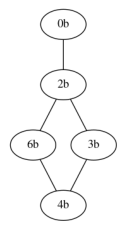

Befores are Square : True
Afters are Square : True
All Befores have same Vertical : 2
All Befores have same Horizontal : 2
All Afters have same Vertical : 6
All Afters have same Horizontal : 6
All Befores and Afters have same Vertical : False
All Befores and Afters have same Horizontal : False
Every Before and After has same Vertical : False
Every Before and After has same Horizontal : False
Common colors : set()
Common colors in all Befores : set()
Common colors in all Afters : {4}
Common colors taken from all Befores : set()
Colors not common in Befores : {2, 3, 4, 6, 7, 8, 9}
Colors not common in Afters : {3, 6, 7, 8, 9}


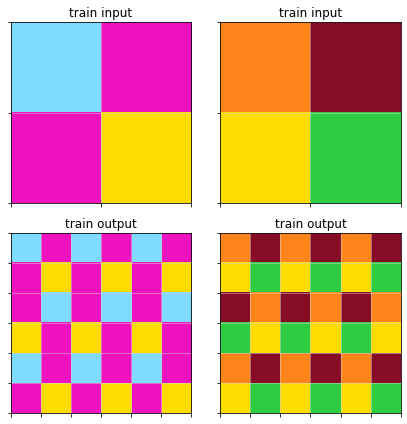

No test output


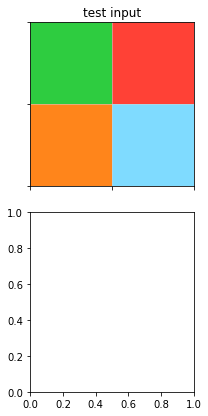

In [192]:
# Load my favorite task
#task_file = str(training_path / training_tasks[1])
task_file = str(test_path / testing_tasks[0])

def load_task(task_file):
    
    print(task_file)
    with open(task_file, 'r') as f:
        task = json.load(f)
        
    logic_color(task, ignore_test_after=True)
    
    analyze(task, ignore_test_after=True)

    print_dict(get_analysis())

    #show_image_list([[[0,1,2,3,4,5,6,7,8,9,10]]])
    plot_task(task)
    
    return task
        
task = load_task(task_file)

# Domain Specific Language (DSL)**

Our DSL will be a collection of functions of type `np.array -> [np.array]` and `[np.array] -> [np.array]`.

The first kind of function take an image, and produce a list of images (for example, the image split by different colors). The second type of function take a list of images and produce a new list (for exemple, intersect).
[](http://)

## DSL Implementation

We start with the functions that take *one image* and produce an *a list of images*.](http://)

!!functions

In [40]:
# np.array -> [np.array]
def groupByColorx_unlifted(pixmap):
    """ Split an image into a collection of images with unique color """    
    # Count the number of colors
    nb_colors = int(pixmap.max()) + 1
    # Create a pixmap for each color
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    # Filter out empty images - might not be needed since done in evaluate
    return [x for x in splited if np.any(x)]

def groupByColor_unlifted(pixmap):
    """ Split an image into a collection of images with unique color """
    #Additions
    #order the output based on common colors in after esp if in before too
    
    # Identify the colors
    rng = np.unique(pixmap)
    
    # Create a pixmap for each color
    splited = [ (pixmap == i) * i for i in rng]
    #splited.append(pixmap)
    return splited

def agroupByColor_unlifted(pixmap):
    """ Split an image into a collection of images with unique color """
    #Additions
    #order the output based on common colors in befores
    global analysis
    
    
    
    # Identify the colors
    rng = list(analysis['Common colors in all Befores'])
    
    # Create a pixmap for each color
    splited = [ (pixmap == i) * i for i in rng]
    #splited.append(pixmap)
    return splited


# np.array -> [np.array]
def cropToContent_unlifted(pixmap):
    """ Crop an image to fit exactly the non 0 pixels """
    
    #Additions
    #Crop to common colors
    #Crop to common After size
    
    # Op argwhere will give us the coordinates of every non-zero point
    true_points = np.argwhere(pixmap)
    if len(true_points) == 0:
        return []
    # Take the smallest points and use them as the top left of our crop
    top_left = true_points.min(axis=0)
    # Take the largest points and use them as the bottom right of our crop
    bottom_right = true_points.max(axis=0)
    # Crop inside the defined rectangle
    res = pixmap[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
    return [res]

# np.array -> [np.array]
def splitH_unlifted2(pixmap):
    """ Split horizontally an image """
    h = pixmap.shape[0]
    if h % 2 == 1:
        h = h // 2
        return [pixmap[:h,:], pixmap[h+1:,:]]
    else:
        h = h // 2
        return [pixmap[:h,:], pixmap[h:,:]]
    
    
def splitHn_unlifted(pixmap):
    """ Split horizontally an image """
    
    #Additions
    #Split using common colors in before (not black first)
    #Split based on common after horizontal size change
    
    ## find the split point based on the vertical line in the image
    #look for vertical lines (unchnging color)
    d=np.diff(pixmap, axis=0)
    da=np.sum(np.abs(d), axis=0)  #columns with 0 are split options
    loc=np.where(da == 0)[0]
    im=[pixmap]
    for p in loc:
        #print(p)
        im.append(pixmap[:,:p]) # left half no line
        im.append(pixmap[:,p+1:])  # right half with no line

    return(im)

def splitH_unlifted(pixmap):
    """ Split horizontally an image """
    
    #Additions
    #Split using common colors in before (not black first)
    #Split based on common after horizontal size change
    
    ## find the split point based on the vertical line in the image
    #look for vertical lines (unchnging color)
    d=np.diff(pixmap, axis=0)
    da=np.sum(np.abs(d), axis=0)  #columns with 0 are split options
    loc=np.where(da == 0)[0]
    im=[pixmap]
    for p in loc:
        #print(p)
        im.append(pixmap[:,p:]) # right half with line
        im.append(pixmap[:,:p+1]) # left half with line
    return(im)


def splitV_unlifted(pixmap):
    """ Split horizontally an image """
    
    #Additions
    #Split using common colors in before (not black first)
    #Split based on common after vertical size change
    # Split on diagonal
    
    ## find the split point based on the horizontal line in the image
    #look for horizontal lines (unchnging color)
    d=np.diff(pixmap, axis=1)
    da=np.sum(np.abs(d), axis=1)  #rows with 0 are split options
    loc=np.where(da == 0)[0]
    im=[pixmap]
    for p in loc:
        #print(p)
        im.append(pixmap[p:,:]) # bot half with line
        im.append(pixmap[:p+1,:]) # top half with line
    return(im)

def splitVn_unlifted(pixmap):
    """ Split horizontally an image """
    
    #Additions
    #Split using common colors in before (not black first)
    #Split based on common after vertical size change
    # Split on diagonal
     
    ## find the split point based on the horizontal line in the image
    #look for horizontal lines (unchnging color)
    d=np.diff(pixmap, axis=1)
    da=np.sum(np.abs(d), axis=1)  #rows with 0 are split options
    loc=np.where(da == 0)[0]
    im=[pixmap]
    for p in loc:
        #print(p)
        im.append(pixmap[:p,:]) # top half no line
        im.append(pixmap[p+1:,:])  # bot half with no line
    return(im)



def splitRD_unlifted(pixmap):
    """ Split diagonally an image """
    
    #Additions
    #Split using common colors in before (not black first)
    #Split based on common after vertical size change
    # Split on diagonal
    
    ## find the split point based on the horizontal line in the image
    #look for horizontal lines (unchnging color)

    (v,h) = pixmap.shape
    im=[pixmap]
    if(v+h>4):
        di = np.zeros((v+h-3, min(v,h)+1))

        #create diagonal and find difference to search for solid diag
        for t in range(2-v,h-1):
            m = np.diag(pixmap,k=t)
            p = 1+min(v,h)-len(m)
            mp = np.pad(m,(1,p),mode = 'edge')
            mpd =np.diff(mp) 
            #print("t=",t,"mp=",mp)
            i=t-(2-v)

            di[i] = mpd

        #print("di=",di)
        da=np.sum(np.abs(di), axis=1)  #rows with 0 are split options
        loc=np.where(da == 0)[0]-v+2   
        #print("loc=",loc)

        
        for p in loc:
            #print(p)
            im.append(np.triu(pixmap,k=p)) # top part with line
            im.append(np.tril(pixmap,k=p)) # bottom part with line
    return(im)

def splitLD_unlifted(pixmap):
    res = splitRD_unlifted(np.rot90(pixmap, k=1))
    
    im=[np.rot90(m,k=-1 ) for m in res]
    return(im)
    

# np.array -> [np.array]
def negative_unlifted(pixmap):
    """ Compute the negative of an image (and conserve the color) """
    #Additions
    #choose color based on color changes between before and after
    
    negative = np.logical_not(pixmap).astype(int)
    color = max(pixmap.max(), 1)  ##I think this picks largest color?
    return [pixmap, negative * color]

def extend_unlifted(pixmap):
    """ Create image where original is padded by 30 pixels all around """
    
    #Additions
    #Pad to common size of After image, or rule (factor or addition)
    
    ##Check if already padded enough?  min dim >=90
    if min(pixmap.shape) < 90 :
        padded=np.pad(pixmap, ((30,30), (30, 30)), 'constant', constant_values=(0))
        #return [padded, pixmap]
        return [padded]
    else:
        #return [pixmap, pixmap]
        return [pixmap]
    


def rotate_unlifted(pixmap):   
    
    #Additions
    #Use pattern matching to decide rotation amount
    return [pixmap, np.rot90(pixmap)]# rotated image by 90 deg

def mirror_unlifted(pixmap):
    return [pixmap, np.fliplr(pixmap)]# mirror image flip H

def tile2_unlifted(pixmap):
    
    #Additions
    #Use Common sizes to identify tiling amount
    
    image =  np.tile(pixmap, (2,2))
    s = image.shape
    h = min(s[0],90)
    v = min(s[1],90)
    #print("h=",h," v=",v)
    return [pixmap, image[:h,:v]]

def tile3_unlifted(pixmap):
    
    #Additions
    #Use Common sizes to identify tiling amount
    
    image =  np.tile(pixmap, (3,3))
    s = image.shape
    h = min(s[0],90)
    v = min(s[1],90)
    #print("h=",h," v=",v)
    return [pixmap, image[:h,:v]]

def atile_unlifted(pixmap):
    
    #Additions
    #Use Common sizes to identify tiling amount
    global analysis
        
    h=3
    v=3
    
    if analysis['All Befores have same Vertical'] and analysis['All Afters have same Vertical']:
        v=int(analysis['All Afters have same Vertical']/analysis['All Befores have same Vertical'])
        v=max(v,1)

    if analysis['All Befores have same Horizontal'] and analysis['All Afters have same Horizontal']:
        h=int(analysis['All Afters have same Horizontal']/analysis['All Befores have same Horizontal'])
        h=max(h,1)
    
    
    image =  np.tile(pixmap, (h,v))
    s = image.shape
    h = min(s[0],90)
    v = min(s[1],90)
    #print("h=",h," v=",v)
    return [pixmap, image[:h,:v]]


def tile3h_unlifted(pixmap):
    
    #Additions
    #Use Common sizes to identify tiling amount
    
    image =  np.tile(pixmap, 3)
    s = image.shape
    h = min(s[0],90)
    v = min(s[1],90)
    #print("h=",h," v=",v)
    return [pixmap, image[:h,:v]]

def tile2h_unlifted(pixmap):
    
    #Additions
    #Use Common sizes to identify tiling amount
    
    image =  np.tile(pixmap, 2)
    s = image.shape
    h = min(s[0],90)
    v = min(s[1],90)
    #print("h=",h," v=",v)
    return [pixmap, image[:h,:v]]

def shift_unlifted(pixmap):
    return # shift image over by 1 to the right

def zoom3_unlifted(pixmap):
    
    #Additions
    #Check if square before using this.  Check common sizes
    
    newshape = np.array(pixmap.shape) * 3
    slices = [ slice(0,old, float(old)/new) for old,new in zip(pixmap.shape,newshape) ]
    coordinates = np.mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    
    return [pixmap, pixmap[tuple(indices)]] # enlarge image taking each 1 pixel and making it 3x3

def azoom_unlifted(pixmap):
    
    #Additions
    #Check if square before using this.  Check common sizes
    global analysis
        
    h=3
    v=3
    
    if analysis['All Afters have same Vertical'] and analysis['All Afters have same Horizontal']:
        v=analysis['All Afters have same Vertical']
        v=max(v,1)
        h=analysis['All Afters have same Horizontal']
        h=max(h,1)
        
        
        newshape = np.array((v,h))
        slices = [ slice(0,old, float(old)/new) for old,new in zip(pixmap.shape,newshape) ]
        coordinates = np.mgrid[slices]
        indices = coordinates.astype('i')   #choose the biggest smaller integer index

        return [pixmap, pixmap[tuple(indices)]] # enlarge image taking each 1 pixel and making it larger
    else:
        return [pixmap]


def zoom2_unlifted(pixmap):

    
    #Additions
    #Check if square before using this.  Check common sizes
    
    newshape = np.array(pixmap.shape) * 2
    slices = [ slice(0,old, float(old)/new) for old,new in zip(pixmap.shape,newshape) ]
    coordinates = np.mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    
    return [pixmap, pixmap[tuple(indices)]] # enlarge image taking each 1 pixel and making it 2x2




def lzoom_unlifted(pixmap):

    return #take small image and turn 1 pixel  2 horizontal, 1 into 3 horizontal  (with mirror and flip this can expand to other cases)



## Composition of functions

It is important to make sure we can chain both functions. It is clear how we can compose two functions `f` and `g` of type `[np.array] -> [np.array]` ; We symply call `g(f([input_image]))`.


For each function of the first type, we need to generated a *lifted version*. A function `np.array -> [np.array]` is can be turned into a function of type `[np.array] -> [np.array]` simply by applying the first function on each image and concatenating the results.

---
If you want to know more about the `lift` function, have a look to the concept of [*monades*](https://en.wikipedia.org/wiki/Monad_%28functional_programming%29). We are indeed using the *list monade*.

In [41]:
def lift(fct):
    # Lift the function
    def lifted_function(xs):
        list_of_results = [fct(x) for x in xs]
        return list(itertools.chain(*list_of_results))
    # Give a nice name to the lifted function
    import re
    lifted_function.__name__ = re.sub('_unlifted$', '_lifted', fct.__name__)
    return lifted_function

cropToContent = lift(cropToContent_unlifted)
groupByColor = lift(groupByColor_unlifted)
splitH = lift(splitH_unlifted)
splitHn = lift(splitHn_unlifted)
splitV = lift(splitV_unlifted)
splitVn = lift(splitVn_unlifted)
negative = lift(negative_unlifted)
extend = lift(extend_unlifted)
rotate = lift(rotate_unlifted)
mirror = lift(mirror_unlifted)
tile2 = lift(tile2_unlifted)
tile3 = lift(tile3_unlifted)
tile2h = lift(tile2h_unlifted)
tile3h = lift(tile3h_unlifted)
zoom3 = lift(zoom3_unlifted)
zoom2 = lift(zoom2_unlifted)

agroupByColor = lift(agroupByColor_unlifted)
atile = lift(atile_unlifted)
azoom = lift(azoom_unlifted)
splitRD = lift(splitRD_unlifted)
splitLD = lift(splitLD_unlifted)

!!test functions

/media/SSD/Abstraction and Reasoning/training/10fcaaa3.json
Befores are Square : False
Afters are Square : False
All Befores have same Vertical : False
All Befores have same Horizontal : False
All Afters have same Vertical : False
All Afters have same Horizontal : False
All Befores and Afters have same Vertical : False
All Befores and Afters have same Horizontal : False
Every Before and After has same Vertical : False
Every Before and After has same Horizontal : False
Common colors : {0}
Common colors in all Befores : {0}
Common colors in all Afters : {0, 8}
Common colors taken from all Befores : set()
Colors not common in Befores : {2, 3, 4, 5, 6}
Colors not common in Afters : {2, 4, 5, 6}


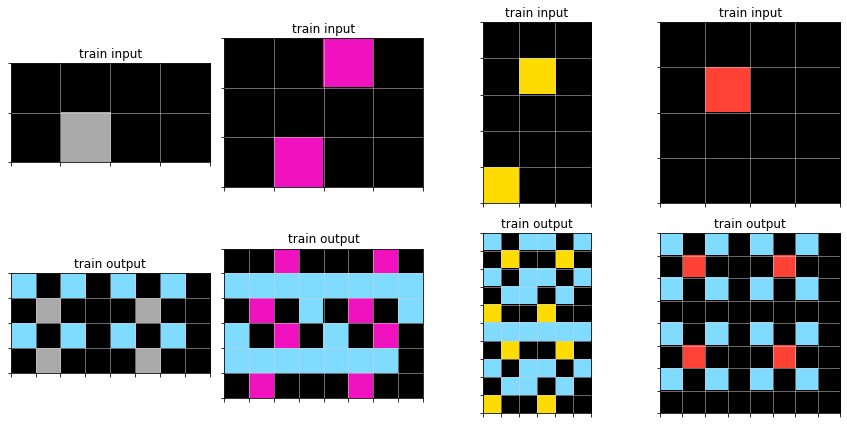

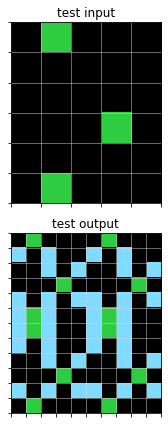

In [42]:
# Load my favorite task
task_file = str(training_path / training_tasks[18])
#task_file = str(test_path / testing_tasks[2])
task = load_task(task_file)

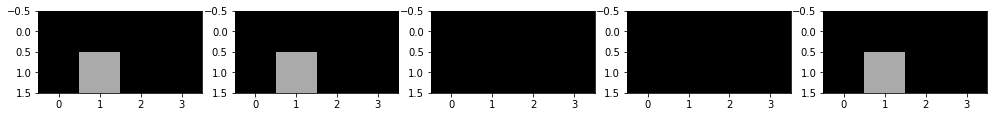

In [43]:

input_image = np.array(task['train'][0]['input'])
imlist = splitLD([input_image])
show_image_list(imlist)

In [44]:
def dedupe(x):
    """ Dedupes a list of images using numpy - string - dict - string - numpy conversion """   
    l1=[str(pixmap.tolist()) for pixmap in x]
    unique_str_list = list(dict.fromkeys(l1))
    x = [np.array(ast.literal_eval(s)) for s in unique_str_list]
    return x

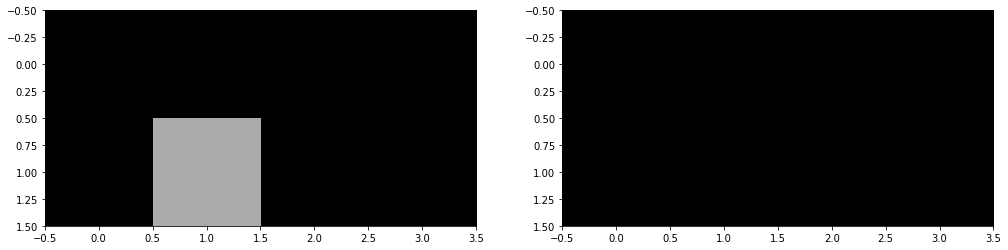

In [45]:
show_image_list(dedupe(imlist))

In [46]:
str(imlist[0].tolist())

'[[0, 0, 0, 0], [0, 5, 0, 0]]'

In [47]:
str(imlist[0])

'[[0 0 0 0]\n [0 5 0 0]]'

!!functions

In [48]:
# [np.array] -> [np.array]
def identity(x: [np.array]):
    return x

# [np.array] -> [np.array]
def tail(x):
    if len(x) > 1:
        return x[1:]
    else:
        return x
    
def head(x):
    if len(x) > 1:
        return x[:-1]
    else:
        return x    
    
def swap(x):

    if len(x) > 1:
        t=x[-1]
        x[-1]=x[-2]
        x[-2]=t
    
    return x   


def dedupe(x):
    """ Dedupes a list of images using numpy - string - dict - string - numpy conversion """   
    l1=[str(pixmap.tolist()) for pixmap in x]
    unique_str_list = list(dict.fromkeys(l1))
    x = [np.array(ast.literal_eval(s)) for s in unique_str_list]
    return x

# [np.array] -> [np.array]
def init(x):
    if len(x) > 1:
        return x[:1]
    else:
        return x

# [np.array] -> [np.array]
def union2(x):
    """ Compute the pixel union of all images in the list. """
    if len(x) < 2:
        return x
    
    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []
    
    return [np.bitwise_or.reduce(np.array(x).astype(int))]
    
def intersect2(x):
    """ Compute the pixel intersection of all images in the list. """
    if len(x) < 2:
        return x
    
    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []
    
    return [(np.prod(np.array(x), axis=0) > 0).astype(int)]

def union(x):
    
    if len(x) < 2:
        return x
    l={}
    # search list to identify shapes and counts
    for pixmap in x:
        s=str(pixmap.shape)
        try:
            l[s].append(pixmap)
        except KeyError:
            l[s]=[pixmap]
    
    im=[]
    for i, k in enumerate(l):
    #print(i, k,len(l[k]))
        if len(l[k])>1:
            mask = (np.logical_or.reduce(np.array(l[k]))).astype(int)
            #print(mask)
            for j,m in enumerate(l[k]):
                #print()
                im.append(np.prod([mask, m], axis=0) )

    return im
    
    
    
    
def intersect(x):
    
    if len(x) < 2:
        return x
    l={}
    # search list to identify shapes and counts
    for pixmap in x:
        s=str(pixmap.shape)
        try:
            l[s].append(pixmap)
        except KeyError:
            l[s]=[pixmap]
    
    im=[]
    for i, k in enumerate(l):
    #print(i, k,len(l[k]))
        if len(l[k])>1:
            mask = (np.prod(np.array(l[k]), axis=0) > 0).astype(int)
            for j,m in enumerate(l[k]):
                #print()
                im.append(np.prod([mask, m], axis=0) )

    return im

#def subtract(x):
        
    #Additions
    #Use set difference to produce a new image from a bunch of existing
    
    
def sortByColor(xs):
    """ Sort pictures by increasing color id. """
    
    #Additions
    #Use common colors to decide 
    
    
    
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: x.max()))

def asortByColor(xs):
    """ Sort pictures by increasing color id. """
    
    #Additions
    #Use common colors to decide 
    global analysis
        
    c=analysis["Common colors in all Afters"]
    
    #for x in xs:
        #print("set=",set(x.flatten().tolist()))
        #print("len=",len(set(x.flatten().tolist()) & c))
    
    # get number of intersecting colors with common
       
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: len(set(x.flatten().tolist()) & c)))

def sortByWeight(xs):
    """ Sort images by how many non zero pixels are contained. """
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: (x>0).sum()))

def reverse(x):
    """ Reverse the order of a list of images. """
    return x[::-1]

def colorshift(x):
    
    
    #Additions
    #Use common colors to shift from before colors to after colors 
    
    
    
    im=[]
    for pixmap in x:
        pixmap=pixmap+1
        pixmap[pixmap==1] = 0 # turn black to black again
        pixmap[pixmap>10] = 1 # rotate to 1
        im.append(pixmap)
    return im

def stackv(x):  ## join images top to bottom
    if len(x) < 2:
        return x
    l={}
    # search list to identify shapes and counts
    for pixmap in x:
        s=pixmap.shape[1]
        try:
            l[s].append(pixmap)
        except KeyError:
            l[s]=[pixmap]
    
    im=[]
    for i, k in enumerate(l):
    #print(i, k,len(l[k]))
        if len(l[k])>1: ## more than one image with this dimension
            im.append(np.vstack(l[k]) )

    return im

def stackh(x):  ## join images top to bottom
    if len(x) < 2:
        return x
    l={}
    # search list to identify shapes and counts
    for pixmap in x:
        s=pixmap.shape[0]
        try:
            l[s].append(pixmap)
        except KeyError:
            l[s]=[pixmap]
    
    im=[]
    for i, k in enumerate(l):
    #print(i, k,len(l[k]))
        if len(l[k])>1: ## more than one image with this dimension
            im.append(np.hstack(l[k]) )

    return im


stack=[]

def push(x):  ## push last image on a stack
    if len(x) < 2:
        return x    
    stack.append(x[-1])
    return x[:-1]

def pull(x):
    if(len(stack)>1):
        x.append(stack.pop())
    elif(len(stack)>0):
        x.append(stack[-1])
    return x
        

# Task

We now load a simple task and execute one of our functions on it.

/media/SSD/Abstraction and Reasoning/training/09629e4f.json
Befores are Square : True
Afters are Square : True
All Befores have same Vertical : 11
All Befores have same Horizontal : 11
All Afters have same Vertical : 11
All Afters have same Horizontal : 11
All Befores and Afters have same Vertical : 11
All Befores and Afters have same Horizontal : 11
Every Before and After has same Vertical : True
Every Before and After has same Horizontal : True
Common colors : {0, 2, 3, 4, 5, 6}
Common colors in all Befores : {0, 2, 3, 4, 5, 6, 8}
Common colors in all Afters : {0, 2, 3, 4, 5, 6}
Common colors taken from all Befores : {8}
Colors not common in Befores : set()
Colors not common in Afters : set()


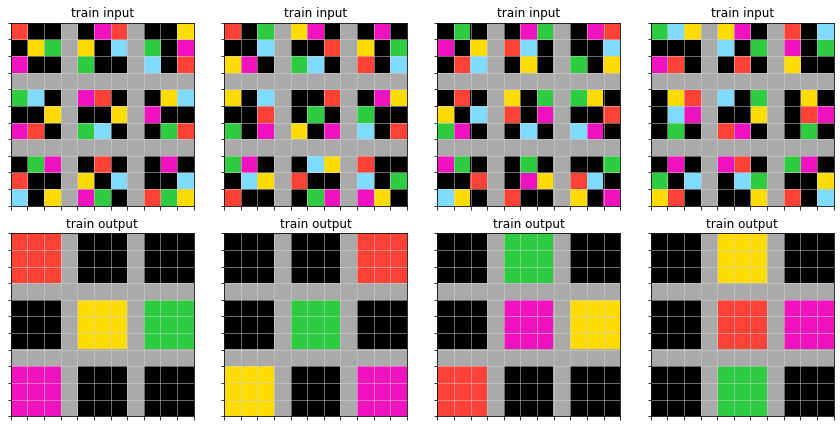

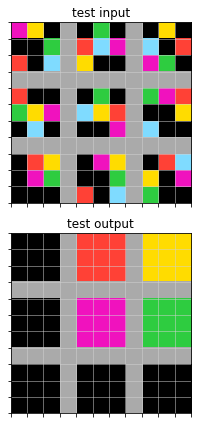

In [49]:
# Load my favorite task
t=10
task_file = str(training_path / training_tasks[t])
task = load_task(task_file)

(11, 11) (11, 11)


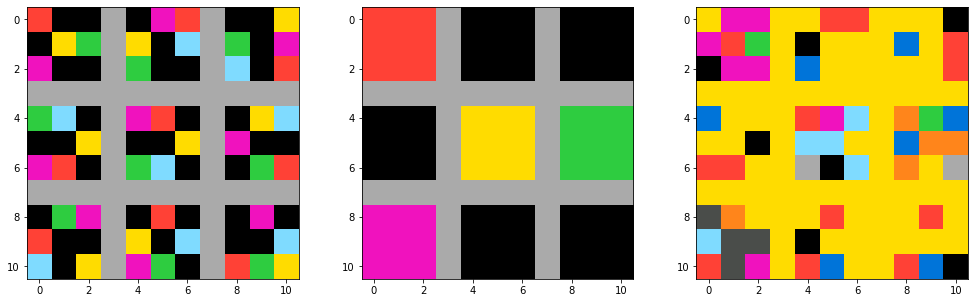

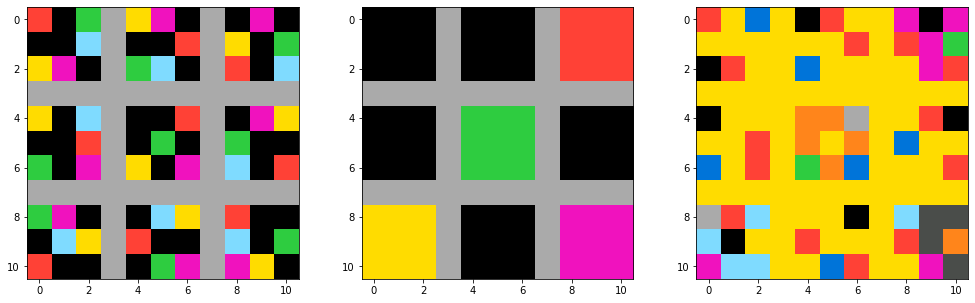

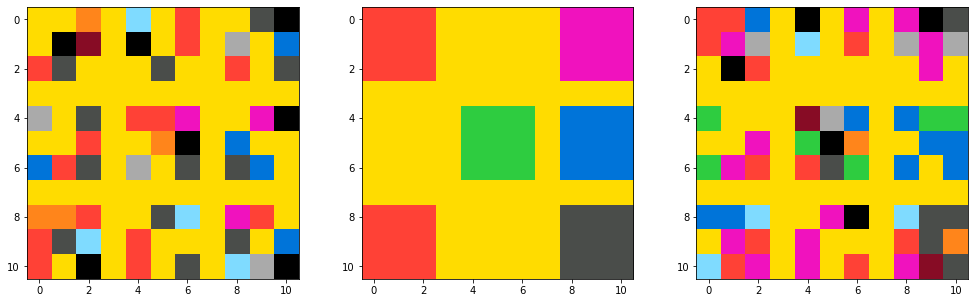

In [50]:
i=0
t=10
task_file = str(training_path / training_tasks[t])
with open(task_file, 'r') as f:
    task = json.load(f)
input_image0 = np.array(task['train'][0]['input'])
output_image0 = np.array(task['train'][0]['output'])
input_image1 = np.array(task['train'][1]['input'])
output_image1 = np.array(task['train'][1]['output'])

print(input_image0.shape, output_image0.shape)

show_image_list([input_image0,output_image0, abs(4+output_image0-input_image0)])
show_image_list([input_image1,output_image1, abs(4+output_image1-input_image1)])
show_image_list([abs(4+input_image1-input_image0),abs(4+output_image1-output_image0), abs(4+abs(4+output_image1-input_image1)-abs(4+output_image0-input_image0))])


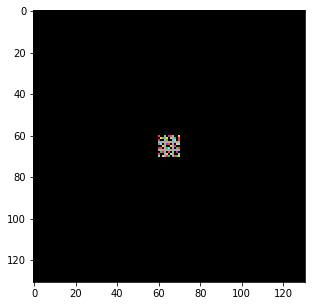

In [51]:
# Execute the group by color on the first input
input_image = np.array(task['train'][0]['input'])
#images = groupByColor([input_image])
images = extend([input_image])
images = extend(images)
images = extend(images)
# Show the result of our function
show_image_list(images)

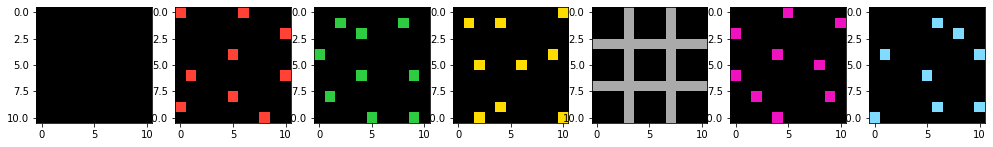

In [52]:
# Execute the group by color on the first input
input_image = np.array(task['train'][0]['input'])
output_image = np.array(task['train'][0]['output'])
images = groupByColor([input_image])

# Show the result of our function
show_image_list(images)

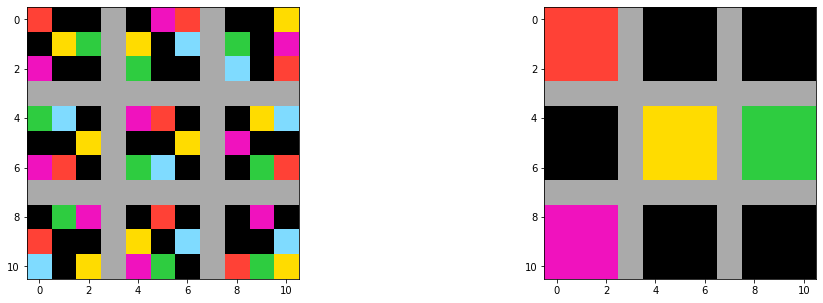

In [53]:
show_image_list([input_image, output_image])


# Program evaluation


We define our building blocks for programs (the functions in our DSL). We will define a program as a list of functions from our DSL ; `program: [[np.array] -> [np.array]]`. The instructions in our programs will be executed *from left to right*. This mean that if we want to first `splitByColor` and then compute the `negative` of the image, we need to write `[splitByColor, negative]` in this order.

Let's first write an utilitary function to describe a program as a human readable string.

!!evaluation

In [54]:
def program_desc(program):
    """ Create a human readable description of a program. """
    desc = [x.__name__.replace("_lifted", "") for x in program]
    return('['+', '.join(desc)+']')

# Display the program description alongside its output
program = [splitH, groupByColor, negative, intersect]
print(program_desc(program))

[splitH, groupByColor, negative, intersect]


## The evaluation method
We need a way to run a such program on a pictures and recover the result. This is done by the `evaluate` function.

In [55]:
def evaluate(program: [], input_image: np.array):
    
    image_list = [np.array(input_image)]
    # Make sure the input is a np.array
    #input_image = np.array(input_image, dtype="int8")
    #input_image = np.array(input_image)
    #assert type(input_image) == np.ndarray
    
    # Apply each function on the image
    #image_list = [input_image]
    for fct in program:
        # Apply the function
        #image_list.append(input_image)  ##try this to get input in every step
        image_list = fct(image_list)
        # Filter out empty images
        image_list = [img for img in image_list if img.shape[0] > 0 and img.shape[1] > 0]
        # Break if there is no data
        #if image_list == []:
            #return []
    return image_list[-20:]       ## limit image list to 20   

## Simple test on a task
We apply the simple program `[groupByColor, negative]` on the task we loaded earlier.

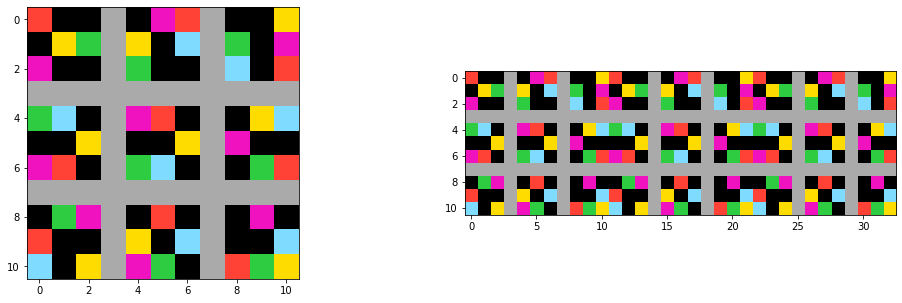

In [56]:
# [tile3h, mirror,head,tile3h,stackv]

results = evaluate(program=[tile3h], input_image=task['train'][0]['input'])
show_image_list(results)

In [57]:
%%timeit
#[tile3h, splitHn, splitVn, reverse, intersect]
results = evaluate(program=[intersect], input_image=task['train'][0]['input'])


9.2 µs ± 48 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


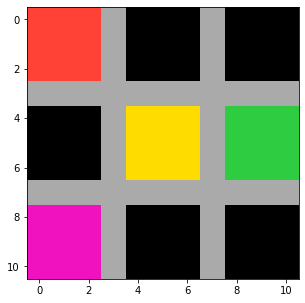

In [58]:
show_image_list([np.array(task['train'][0]['output'])])

# Program generation

We now have a simple and powerful language to express various transformation on images. But someone or something still have to write the actual program that can solve a task. In this part, we will implement a naive but somewhat efficient genetic algorithm that will be able to find by itself the solution to a task.

## Is a program solution

First, we need a way to know if a program is a solution of the given examples of a task.

!!is solution

In [59]:
def are_two_images_equals(a, b):
    if tuple(a.shape) == tuple(b.shape):
        if (np.abs(b-a) < 1).all():
            return True
    return False

def is_solution(program, task, verbose=True):
    for sample in task: # For each pair input/output
        
        i = np.array(sample['input'])
        o = np.array(sample['output'])

        # Evaluate the program on the input
        images = evaluate(program, i)
        if len(images) < 1:
            return False
        
        # The solution should be in the 3 last outputs
        images = images[-3:]
        #print("Images=",images) #debug
        # Check if the output is in the 3 images produced
        is_program_of_for_sample = any([are_two_images_equals(x, o) for x in images])
        if not is_program_of_for_sample:
            return False
    
    return True

program = [tile3h, mirror,head,tile3h,stackv]
print(program_desc(program),"is a solution of the task:", is_solution(program, task['train']))

[tile3h, mirror, head, tile3h, stackv] is a solution of the task: False


/media/SSD/Abstraction and Reasoning/training/007bbfb7.json
Befores are Square : True
Afters are Square : True
All Befores have same Vertical : 3
All Befores have same Horizontal : 3
All Afters have same Vertical : 9
All Afters have same Horizontal : 9
All Befores and Afters have same Vertical : False
All Befores and Afters have same Horizontal : False
Every Before and After has same Vertical : False
Every Before and After has same Horizontal : False
Common colors : {0}
Common colors in all Befores : {0}
Common colors in all Afters : {0}
Common colors taken from all Befores : set()
Colors not common in Befores : {2, 4, 6, 7}
Colors not common in Afters : {2, 4, 6, 7}


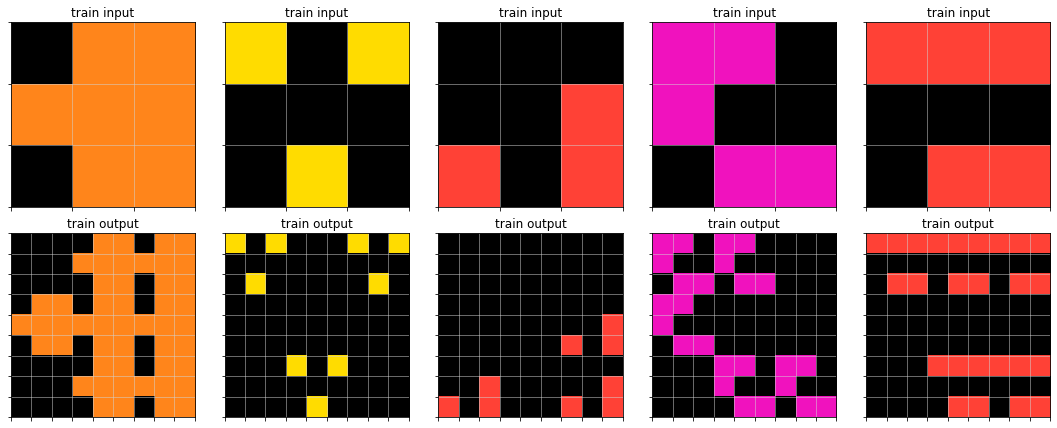

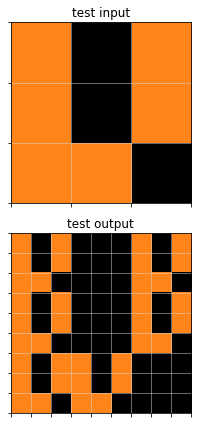

In [73]:
# Load my favorite task
task_file = str(training_path / training_tasks[0])
task = load_task(task_file)

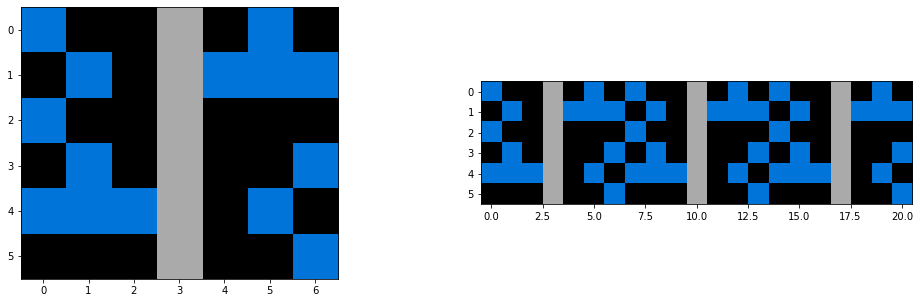

In [61]:
images = evaluate(program=[tile3h,mirror,stackv], input_image=task['train'][0]['input'])
#images = images[-3:]
show_image_list(images)

In [62]:
# see https://stackoverflow.com/questions/7670112/finding-a-subimage-inside-a-numpy-image


def subimg_location(haystack, needle):
    
    try:
        
        haystack_str = b"".join(48+haystack.flatten().astype(np.dtype('b'))).decode("latin-1") 
        needle_str = b"".join((48+needle.flatten()).astype(np.dtype('b'))).decode("latin-1") 
    except:
        print("needle=",needle)
        print("type=",type(needle))
        print("shape=",needle.shape)
        print("temp=",temp)
        print(" ")
    

    gap_size = (haystack.shape[1] - needle.shape[1]) 
    
    #print(gap_size)
    gap_regex = '.{' + str(gap_size) + '}'

    #print(gap_regex)
    # Split b into needle.size[0] chunks
    chunk_size = needle.shape[1] 
    split = [needle_str[i:i+chunk_size] for i in range(0, len(needle_str), chunk_size)]

    # Build regex
    regex = re.escape(split[0])
    for i in range(1, len(split)):
        regex += gap_regex + re.escape(split[i])

    p = re.compile(regex)
    m = p.search(haystack_str)

    if not m:
        return False

    x, _ = m.span()

    left = x % (haystack.shape[1] ) 
    top  = int(x / haystack.shape[1] )

    return (top, left)

## Fitness

To help our algorithm progress in the right direction, we need a way to give a score to an existing program. The smaller is the score of the program, the closer we are to the solution. One can think of this score as a distance of our program to the optimal solution.

Notice that one can think of this program as a minimization problem (minimize `score`) or maximization problem (minimize `-score`). On machine learning it is common to minimise a distance wereas in genetic algorithm literature you can read that we maximize the fitness of an agent. Both convention work perfectly, but it is more convenient if we choose one and stick to it. Therefore, we will MINIMIZE the score of our programs.

First, we are going to evaluate how our program perform on different aspects.

!!fitness

In [63]:



def width_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right width. Less is better."""
    return np.abs(predicted.shape[0] - expected_output.shape[0])

def height_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right height. Less is better."""
    return np.abs(predicted.shape[1] - expected_output.shape[1])

def activated_pixels_fitness(p, e):
    """ How close the predicted image to have the right pixels. Less is better."""
    shape = (max(p.shape[0], e.shape[0]), max(p.shape[1], e.shape[1]))
    diff = np.zeros(shape, dtype=int)
    diff[0:p.shape[0], 0:p.shape[1]] = (p > 0).astype(int)
    diff[0:e.shape[0], 0:e.shape[1]] -= (e > 0).astype(int)
    
    fit = (diff != 0).sum()
    
    return fit


def submatch_fitness(p,e):
    
    (py,px) = p.shape
    (ey,ex) = e.shape
    
    if px<=ex and py<=ey:
        
        r = subimg_location(haystack=e,needle=p)
    
    elif px>=ex and py>=ey:
        r = subimg_location(haystack=p,needle=e)
    elif px<ex and py>=ey:
        
        r = subimg_location(haystack=e[:,:px],needle=p)
    elif px>=ex and py<ey:
 
        r = subimg_location(haystack=e[:py,:],needle=p)
    else:
        print("whats up",px,ex,py,ey)
            
    if r == False:
        return 1
    else:
        #print(r)
        return 0
        

def pixels_match_fitness(p,e):
    shape = (max(p.shape[0], e.shape[0]), max(p.shape[1], e.shape[1]))
    #check how many pixels match the expected output.
    p1 = np.zeros(shape, dtype=int)
    e1 = np.zeros(shape, dtype=int)
    
    p1[0:p.shape[0], 0:p.shape[1]] = p
    e1[0:e.shape[0], 0:e.shape[1]] = e
    
    #q=np.abs(p1-e1).sum() + abs(e.shape[0]-p.shape[0])*abs(e.shape[1]-p.shape[1])
    q=np.abs(p1-e1).sum()
    
    s=submatch_fitness(p,e)
    
    return q*(1+5*s)
    

def colors_fitness(p, e):
    p_colors = np.unique(p)
    e_colors = np.unique(e)
    
    nb_inter = len(np.intersect1d(p_colors, e_colors))

    return (len(p_colors) - nb_inter) + (len(e_colors) - nb_inter)

fitness_functions = [colors_fitness, activated_pixels_fitness, height_fitness, width_fitness, pixels_match_fitness]


The fitness score (less is better) of our function will be a 4-dimensional tuple containing the result of each of the fitness functions.

We want to be able to compare two score. Unfortunately, the *lixocographical order* is not adapted, as there is no reason than having a small `width score` is better than having a small `height score`. We are going to define a partial order that give the same weight to any fitness function.

When we compare two tuple with this partial order, `(3, 2, 4, 0) < (3, 2, 5, 0)` and `(3, 2, 4, 0) < (4, 2, 4, 0)`. But there is no way to compare `(3, 2, 5, 0)` and `(4, 2, 4, 0)`. We say this two values are *incomparable*. If two score are incomparable, it means that we cannot say that one program is better than the over.

In [64]:
def product_less(a, b):
    """ Return True iff the two tuples a and b respect a<b for the partial order. """
    a = np.array(a)
    b = np.array(b)
    return (np.array(a) < np.array(b)).all()
    

We now write a function that evaluate the fitness of a program on a task.

In [65]:
# ([[np.array] -> [np.array]], Taks) -> (int, int, ..., int)
def evaluate_fitness(program, task):
    """ Take a program and a task, and return its fitness score as a tuple. """
    score = np.zeros((len(fitness_functions)+1))
    
    # For each sample
    for sample in task:
        i = np.array(sample['input'])
        o = np.array(sample['output'])
        images = evaluate(program, i)
        
        # For each fitness function
        for index, fitness_function in enumerate(fitness_functions):
            #images = evaluate(program, i)   ### This can be pulled out of loop
            if images == []: # Penalize no prediction!
                score[index] += 500
            else: # Take only the score of the last 3 outputs
                score[index]=0
                im3=images[-3:]
                for imct in range(len(im3)):
                    score[index] = score[index] + fitness_function(im3[imct], o)/len(im3)
        index=index+1
        score[index]=len(images)  ## add a fitness function that penalizes # images
                
    return tuple(score)

print("Fitness evaluation:", evaluate_fitness([tile3,], task['train']))

Fitness evaluation: (3.0, 58.0, 11.0, 3.0, 720.0, 2.0)


In [66]:
print("Fitness evaluation:", evaluate_fitness([tile3h], task['train']))
print("Fitness evaluation:", evaluate_fitness([tile3h, mirror], task['train']))
print("Fitness evaluation:", evaluate_fitness([tile3h, mirror,head], task['train']))
print("Fitness evaluation:", evaluate_fitness([tile3h, mirror,head,tile3h], task['train']))
print("Fitness evaluation:", evaluate_fitness([tile3h, mirror,head,tile3h,stackv], task['train']))


Fitness evaluation: (3.0, 22.0, 11.0, 0.0, 288.0, 2.0)
Fitness evaluation: (3.0, 26.0, 13.333333333333332, 0.0, 336.0, 4.0)
Fitness evaluation: (3.0, 18.0, 8.666666666666666, 0.0, 240.0, 3.0)
Fitness evaluation: (3.0, 58.0, 32.0, 0.0, 720.0, 6.0)
Fitness evaluation: (3.0, 64.0, 11.0, 4.5, 792.0, 2.0)


## Asexual reproduction

Now that we can compare two programs we need a way to generate some of them. We will generate them randomly from a pool of best candidate.

For the initial run, and also to be able to evaluate fresh candidates, we will also allow spontaneous generation of new born one instruction programs.

!!reproduction

In [67]:
def build_candidates(allowed_nodes=[identity], best_candidates=[], nb_candidates=100):
    """
    Create a poll of fresh candidates using the `allowed_nodes`.
    
    The pool contain a mix of new single instructions programs
    and mutations of the best candidates.
    """
    
    #Additions
    #Choose candidates based on probabilities
    #Choose candidates based on analysis of the task (give rotate higher prob if pattern matching shows rotated ims)
    new_candidates = []
    length_limit = 5 # Maximal length of a program
    
    def random_node():
        return random.choice(allowed_nodes)
    
    # Until we have enougth new candidates
    while(len(new_candidates) < nb_candidates):
        # Add 10 new programs
        for i in range(5):
            new_candidates += [[random_node()]]
        
        # Create new programs based on each best candidate
        for best_program in best_candidates:
            # Add one op on its right but limit the length of the program
            if len(best_program) < length_limit - 1:
                new_candidates += [[random_node()] + best_program]
            # Add one op on its left but limit the length of the program
            if len(best_program) < length_limit - 1:
                new_candidates += [best_program + [random_node()]]
            # Mutate one instruction of the existing program
            new_candidates += [list(best_program)]
            new_candidates[-1][random.randrange(0, len(best_program))] = random_node()
   
    # Truncate if we have too many candidates
    np.random.shuffle(new_candidates)
    return new_candidates[:nb_candidates]

# Test the function by building some candidates
len(build_candidates(allowed_nodes=[identity], best_candidates=[[identity]], nb_candidates=42))

42

## Find a program given a task

This is the last step to our genetic algorithm. We have all the building blocks:
 * Generating both new programs and mutation of existing solutions
 * Evaluating the fitness score of a program
 * Comparing two programs to know if one perform better than the other
 * Detecting when a solution was found
 
We can now write a function that will keep generating programs with increasing complexity until a solution is found.

Using our partial order, we are going to keep the best candidates. Because the order is partial,
there is no bound on how many uncomparables candidates we may have at a given iteration.

!!build

In [68]:

def build_model(task, max_iterations=20, verbose=True):
    
    #Additions
    #Convert a task to numpy arrays once instead of in each eval
    
    
    
    candidates_nodes = [
        intersect,
        
        cropToContent, groupByColor, splitH, splitV,splitVn, splitHn,
        tile2,tile3,zoom3,zoom2,union,sortByColor, mirror,rotate,colorshift,
        tile2h,tile3h,stackh,stackv,head,
        init,tail, sortByWeight, reverse, negative,swap,
        
        agroupByColor,atile,asortByColor,dedupe
        
        #extend,push,pull,dedupe,azoom,splitRD,splitLD

    ]
    
    #print("Task=",task)
    #print("max_iterations=",max_iterations)
    #print('verbose=',verbose)
    print(".")
    if verbose:
        print("Candidates nodes are:", [program_desc([n]) for n in candidates_nodes])
        print()

    best_candidates = {} # A dictionary of {score:candidate}
    for i in range(max_iterations):
        if verbose:
            print("Iteration ", i+1)
            print("-" * 10)
        
        # Create a list of candidates
        candidates = build_candidates(candidates_nodes, best_candidates.values())
        
        # Keep candidates with best fitness.
        # They will be stored in the `best_candidates` dictionary
        # where the key of each program is its fitness score.
        for candidate in candidates:
            score = evaluate_fitness(candidate, task)
            is_uncomparable = True # True if we cannot compare the two candidate's scores
            
            # Compare the new candidate to the existing best candidates
            best_candidates_items = list(best_candidates.items())
            for best_score, best_candidate in best_candidates_items:
                if product_less(score, best_score):
                    # Remove previous best candidate and add the new one
                    del best_candidates[best_score]
                    best_candidates[score] = candidate
                    is_uncomparable = False # The candidates are comparable
                if product_less(best_score, score) or best_score == score:
                    is_uncomparable = False # The candidates are comparable
            if is_uncomparable: # The two candidates are uncomparable
                best_candidates[score] = candidate

        # For each best candidate, we look if we have an answer
        for program in best_candidates.values():
            if is_solution(program, task):
                return program
            
        # Give some informations by selecting a random candidate
        if verbose:
            print("Best candidates length:", len(best_candidates))
            random_candidate_score = random.choice(list(best_candidates.keys()))
            print("Random candidate score:", random_candidate_score)
            print("Random candidate implementation:", program_desc(best_candidates[random_candidate_score]))
    return None

# Solving the task

We now apply our knowledge to solving the first task presented. We will run our algorithm and see how long it takes to generate a program that can solve the task. You may run the folowing cell multiple times to see the variance into how long the algorithm takes to find the answer.

/media/SSD/Abstraction and Reasoning/test/009d5c81.json
Befores are Square : True
Afters are Square : True
All Befores have same Vertical : 14
All Befores have same Horizontal : 14
All Afters have same Vertical : 14
All Afters have same Horizontal : 14
All Befores and Afters have same Vertical : 14
All Befores and Afters have same Horizontal : 14
Every Before and After has same Vertical : True
Every Before and After has same Horizontal : True
Common colors : {0}
Common colors in all Befores : {0, 8, 1}
Common colors in all Afters : {0}
Common colors taken from all Befores : {8, 1}
Colors not common in Befores : set()
Colors not common in Afters : {2, 3, 7}


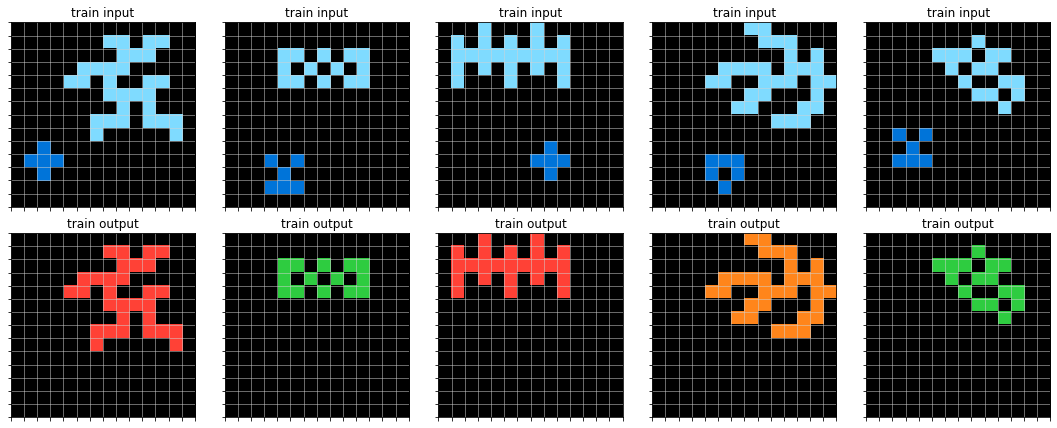

No test output


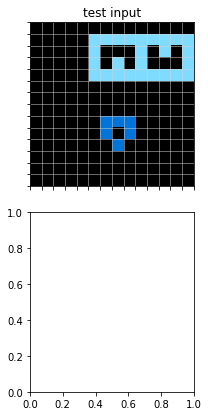

In [69]:
# Load my favorite task
#task_file = str(training_path / training_tasks[7])
task_file = str(test_path / testing_tasks[1])
task = load_task(task_file)
    

* Use the same pool and test other problems while solving - don't just solve one problem at a time.
* look at parallelizing it

# Processing the data

!!processing

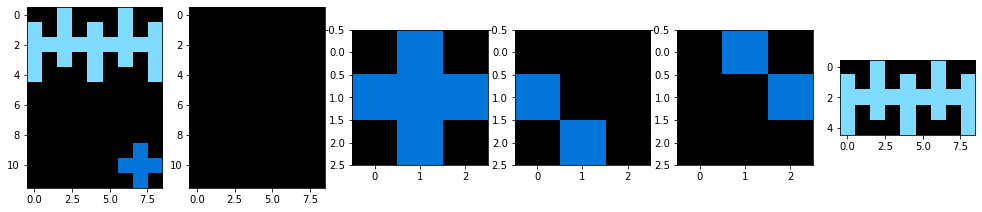

In [71]:
images = evaluate(program=[splitLD, splitV, cropToContent, splitRD,dedupe], input_image=task['train'][2]['input'])
#images = images[-3:]
show_image_list(images)

In [38]:
l=[0,1,2,3,4,5,6,7,8,9]

In [39]:
l[-3:]

[7, 8, 9]

In [75]:
#Run task analysis
analyze(task,ignore_test_after = True)
program = build_model(task['train'],max_iterations=100, verbose=True)

print()
if program is None:
    print("No program was found")
else:
    print("Found program:", program_desc(program))

.
Candidates nodes are: ['[intersect]', '[cropToContent]', '[groupByColor]', '[splitH]', '[splitV]', '[splitVn]', '[splitHn]', '[tile2]', '[tile3]', '[zoom3]', '[zoom2]', '[union]', '[sortByColor]', '[mirror]', '[rotate]', '[colorshift]', '[tile2h]', '[tile3h]', '[stackh]', '[stackv]', '[head]', '[init]', '[tail]', '[sortByWeight]', '[reverse]', '[negative]', '[swap]', '[agroupByColor]', '[atile]', '[asortByColor]', '[dedupe]']

Iteration  1
----------
Best candidates length: 12
Random candidate score: (1.0, 25.0, 6.0, 6.0, 50.0, 1.0)
Random candidate implementation: [agroupByColor]
Iteration  2
----------
Best candidates length: 27
Random candidate score: (0.0, 140.0, 6.0, 6.0, 1680.0, 4.0)
Random candidate implementation: [zoom3, atile]
Iteration  3
----------
Best candidates length: 58
Random candidate score: (0.0, 66.66666666666666, 4.0, 4.0, 800.0, 4.0)
Random candidate implementation: [tile2, zoom3]
Iteration  4
----------

Found program: [zoom3, atile, intersect]


In [ ]:
answer = evaluate(eval(program_desc(program)), input_image=task['test'][0]['input'])
print("Answer:", is_solution(eval(program_desc(program)), task['test']))
show_image_list(answer)

In [ ]:
program = save_build_model(training_tasks[13],
                           task_path = training_path,
                           prog_path=program_path,
                           max_iterations=100,
                           verbose=True)

print()
if program is None:
    print("No program was found")
else:
    print("Found program:", program_desc(program))

In [ ]:
program_desc(program)

In [26]:
def save_build_model(taskfn, task_path = training_path, prog_path=program_path,max_iterations=20, verbose=True):
    task_file = str(task_path / taskfn)
    with open(task_file, 'r') as f:
        task = json.load(f)
     
    #plot_task(task)
    analyze(task,ignore_test_after = True)
    program = build_model(task=task['train'],max_iterations=max_iterations, verbose=verbose)
    if program is None:
        print("No program was found for task: ", taskfn)
    else:
        print("Program was found for task: ", taskfn, "= ",program_desc(program))
        prog_file = program_path/("prog_"+taskfn)
        with open(prog_file, 'w') as f:
            json.dump(program_desc(program), f)
        
    return program

In [27]:
program_path = data_path/'programs/test'
for i in testing_tasks:
    program = save_build_model(i,test_path,program_path,5,False)

.
No program was found for task:  00576224.json
.
No program was found for task:  009d5c81.json
.
No program was found for task:  00dbd492.json
.
No program was found for task:  03560426.json
.
No program was found for task:  05a7bcf2.json
.
No program was found for task:  0607ce86.json
.
No program was found for task:  0692e18c.json
.
No program was found for task:  070dd51e.json
.
No program was found for task:  08573cc6.json
.
No program was found for task:  0934a4d8.json
.
No program was found for task:  09c534e7.json
.
No program was found for task:  0a1d4ef5.json
.
No program was found for task:  0a2355a6.json
.
No program was found for task:  0b17323b.json
.
No program was found for task:  0bb8deee.json
.
No program was found for task:  0becf7df.json
.
No program was found for task:  0c786b71.json
.
No program was found for task:  0c9aba6e.json
.
No program was found for task:  0d87d2a6.json
.
No program was found for task:  0e671a1a.json
.
No program was found for task:  0f63c0

In [ ]:
program_path = data_path/'programs/test'
num_cores = multiprocessing.cpu_count()
print(num_cores)

programs = Parallel(n_jobs=num_cores-2)(delayed(save_build_model)
                                        (i,test_path,program_path,100,False) for i in testing_tasks)



12


In [31]:
testing_tasks

['00576224.json',
 '009d5c81.json',
 '00dbd492.json',
 '03560426.json',
 '05a7bcf2.json',
 '0607ce86.json',
 '0692e18c.json',
 '070dd51e.json',
 '08573cc6.json',
 '0934a4d8.json',
 '09c534e7.json',
 '0a1d4ef5.json',
 '0a2355a6.json',
 '0b17323b.json',
 '0bb8deee.json',
 '0becf7df.json',
 '0c786b71.json',
 '0c9aba6e.json',
 '0d87d2a6.json',
 '0e671a1a.json',
 '0f63c0b9.json',
 '103eff5b.json',
 '11e1fe23.json',
 '12422b43.json',
 '12997ef3.json',
 '12eac192.json',
 '136b0064.json',
 '13713586.json',
 '137f0df0.json',
 '140c817e.json',
 '14754a24.json',
 '15113be4.json',
 '15663ba9.json',
 '15696249.json',
 '16b78196.json',
 '17b80ad2.json',
 '17cae0c1.json',
 '18419cfa.json',
 '184a9768.json',
 '195ba7dc.json',
 '1990f7a8.json',
 '19bb5feb.json',
 '1a2e2828.json',
 '1a6449f1.json',
 '1acc24af.json',
 '1c02dbbe.json',
 '1c0d0a4b.json',
 '1c56ad9f.json',
 '1d0a4b61.json',
 '1d398264.json',
 '1da012fc.json',
 '1e81d6f9.json',
 '1e97544e.json',
 '2037f2c7.json',
 '2072aba6.json',
 '20818e16

In [ ]:
#load tasks into mem
tasklist=[]
for taskit in range(400):
    #print("Task",taskit)
    task_file = str(training_path / training_tasks[taskit])
    with open(task_file, 'r') as f:
        task = json.load(f)
        tasklist.append(task)

In [ ]:
num_cores = multiprocessing.cpu_count()
print(num_cores)

programs = Parallel(n_jobs=num_cores-2)(delayed(build_model)(i['train'],100,False) for i in tasklist)



* Write out to a file for each run, with the log.

In [ ]:
len(programs)

In [ ]:
len(testing_tasks)

In [ ]:
count=0
for taskit in range(400):
    print("Task",taskit)
    task = tasklist[taskit]
        
    program = programs[taskit]
    if program is None:
        print("No program was found for:",taskit)
    else:
        count=count+1
        print("Task:",taskit," total:", count," Found program:", program_desc(program))
        plot_task(task)
        answer = evaluate(eval(program_desc(program)), input_image=task['test'][0]['input'])
        print("Answer:", is_solution(eval(program_desc(program)), task['test']))
        show_image_list(answer)
        
print("Total:",count)
        
        

In [ ]:
answer = evaluate(eval(program_desc(program)), input_image=task['test'][0]['input'])
show_image_list(answer)

In [ ]:
results[5]

In [ ]:
program

In [ ]:
eval(program_desc(results[5]))

In [ ]:
program_desc(program)

In [ ]:
program_desc(results[5])

# Conclusion

The actual search space is of size `4 194 304 = 4**11`. This is the total number of programs that can be build.
It is impressive that in such a huge space a simple algorithm as this one can find a solution so fast.

Nethertheless, there is a huge room for improvement.

Here is a small list of ideas.

* Add more fitness functions that would allow a faster convergence,
* Keep more than one candidate per local minima found,
* Extend the DSL to functions that allow solving more tasks,
* Sample the candidate pool with probabilities according to the best candidates scores,
* Add *sexual reproduction* to the programs, aka crossover.

If you read so far, thanks you for staying with me all along. I hope this can help / inspire you.

Please feel comfortable to comment. 🙂

In [ ]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

In [ ]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred


In [ ]:
example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
display(example_grid)
print(flattener(example_grid))

* To Do - try each with 20 iterations and then work on harder ones in a second pass
* Add time monitoring for 9 hrs
* return best 3 programs when nothing found

In [ ]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
        
    program = build_model(task['train'],max_iterations=2, verbose=False)
    if program is None:
        print("No program was found for:",f)
        
        # skipping over the training examples, since this will be naive predictions
        # we will use the test input grid as the base, and make some modifications
        data = task['test'][pair_id]['input'] # test pair input
        # for the first guess, predict that output is unchanged
        pred_1 = flattener(data)
        # for the second guess, change all 0s to 5s
        data = [[5 if i==0 else i for i in j] for j in data]
        pred_2 = flattener(data)
        # for the last gues, change everything to 0
        data = [[0 for i in j] for j in data]
        pred_3 = flattener(data)
        pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
        
    else:
        count=count+1
        print("Task:",f," total:", count," Found program:", program_desc(program))
        results = evaluate(program=program, input_image=task['test'][pair_id]['input'])
        pred=""
        ct=min(3,len(results))
        for i in range(ct):
            x=results[i]
            x[x>9] = 0 # change extra color to background if it exists
            pred = pred + flattener(x.to_list()) + ' '
         
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission.csv')


!!end